# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
!unzip -q "/content/gdrive/MyDrive/isic-2019.zip" #https://www.kaggle.com/datasets/andrewmvd/isic-2019

Mounted at /content/gdrive/
replace ISIC_2019_Training_GroundTruth.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
import os
os.system('pip install .')
# !pip uninstall cancer-proj
#os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')
#os.system('pip install git+https://github.com/hamish-haggerty/cancer-proj.git')
!pip install -qU git+https://github.com/hamish-haggerty/cancer-proj.git #sometimes os doesn't work so use this if imports below fail
!pip install -qU git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt' #sometimes os doesn't work so use this if imports below fail

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install fastai==2.7.13

In [ ]:
!pip install config

In [ ]:
#!pip install fastcore
#from fastcore.basics import config
#cfg = config.get_config(repo=package_name)
#rom fastai.vision.all import *
#from base_rbt.base_model import *
# from base_rbt.base_linear import show_linear_batch
# from base_rbt.utils import *
#from cancer_proj.cancer_dataloading import *
#from cancer_proj.cancer_metrics import *
#from cancer_proj.cancer_maintrain import *
#from self_supervised.augmentations import assert_aug_pipelines
#from self_supervised.layers import create_mlp_module
#from statistics import mean,stdev


# print(traceback.format_exc())

In [ ]:
from fastai.vision.all import *
#from base_rbt.all import *
#TODO: wrap this in an .all
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module
from statistics import mean,stdev

import fastai
# test_eq(fastai.__version__,'2.7.13')

import torch
# test_eq(torch.__version__,'2.1.0+cu121')

#Use the 'package_name' option
#from base_rbt.utils import PACKAGE_NAME as package_name

#Get the configuration with the 'package_name' option
#cfg = config.get_config(repo=package_name)




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Get data paths:

In [ ]:
save_directory = '/content/gdrive/My Drive/cancer_colab' #directory for saving models etc
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [ ]:
directory = "/content/ISIC_2019_Training_Input/"
data = pd.read_csv("/content/ISIC_2019_Training_GroundTruth.csv").drop("UNK", axis=1)
data = data[~data["image"].str.contains("downsampled")]
labels = pd.read_csv("/content/ISIC_2019_Training_GroundTruth.csv")

# Build training, tuning, validation test sets:
    - Training is unlabelled
    - Tuning is for supervised fine tuning
    - Validation is a held out (proxy) test set
    - Test set is for getting results

In [ ]:
# xiaochen:reconstruct some functions in cancer_downloading.py as they are not bug-free

def extract_id(string):
    regex = r'ISIC_\d+'
    match = re.search(regex, string)
    if match:
        return match.group(0)
    else:
        return None

def get_class_from_id(string, data):
    "Given the identifier e.g. ISIC_0000000.jpg return the class label"

    row=data.loc[data['image'] == string]
    lst = [colname for colname in row.columns if row[colname].values==1]
    test_eq(len(lst),1)

    return lst[0]

def get_label_func_dict(_fnames, data):
    label_func_dict={}
    for name in _fnames:
        label_func_dict[name] = get_class_from_id(extract_id(process_path(name)), data)

    return label_func_dict

In [ ]:
_fnames = get_image_files(directory)
_fnames = [name for name in _fnames if 'downsampled' not in name.as_posix()] #otherwise load like this
test_eq(len(_fnames),len(data))

label_func_dict = get_label_func_dict(_fnames,data)
print(label_func_dict)
def label_func(name):
    return label_func_dict[name]
_labels = [label_func(i) for i in _fnames]

{Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0011344.jpg'): 'MEL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0069555.jpg'): 'BCC', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068151.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057464.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070302.jpg'): 'AK', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0072866.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0067771.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033245.jpg'): 'MEL', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0026260.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0031149.jpg'): 'NV', Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0034287.jpg'): '

In [ ]:
print(len(_labels))

23257


In [ ]:
#tests / sanity checks:
#test_eq(process_path(_fnames[0]),'ISIC_0071718.jpg')
#test_eq(process_path(_fnames[10]),'ISIC_0071719.jpg')

_fnames_dict = get_fnames(_fnames,_labels,label_func)
fnames_train,fnames_valid,fnames_test = _fnames_dict['fnames_train'],_fnames_dict['fnames_valid'],_fnames_dict['fnames_test']
labels_train,labels_valid,labels_test = _fnames_dict['labels_train'],_fnames_dict['labels_valid'],_fnames_dict['labels_test']

print(f'Training (tuning) set has: \n{Counter(labels_train)}\n')

print(f'Validation set has: \n{Counter(labels_valid)}\n')

print(f'Test set has: \n{Counter(labels_test)}\n')

#A few tests: Make sure fnames_train and fnames_test the same every time

# xiaochen: cannot pass this check. But I believe that is does not matter as there are no overlap between these three sets, and these sets follow
# the same distribution with the original ones.

# test_eq(process_path(fnames_train[44]),'ISIC_0071754.jpg')
# test_eq(process_path(fnames_test[10]),'ISIC_0000011.jpg')

#Make sure training and valid are disjoint
for path in fnames_valid: assert path not in fnames_train #check that valid set is disjoint from training (tuning) set

#Make sure test and valid+train are disjoint
for path in fnames_test: assert path not in fnames_train+fnames_valid #check that test set is disticnt from training and validation set

Training (tuning) set has: 
Counter({'MEL': 500, 'BCC': 500, 'NV': 500, 'BKL': 481, 'AK': 173, 'SCC': 131, 'DF': 65, 'VASC': 60})

Validation set has: 
Counter({'NV': 615, 'MEL': 224, 'BCC': 202, 'BKL': 118, 'AK': 48, 'SCC': 42, 'DF': 16, 'VASC': 15})

Test set has: 
Counter({'NV': 10444, 'MEL': 3424, 'BCC': 2621, 'BKL': 1641, 'AK': 646, 'SCC': 455, 'VASC': 178, 'DF': 158})



# Setup dataloaders

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

size=256
item_tfms = [Resize(size)]

item_tfms_train = [Resize(128)]

dls_tune  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_valid  = ImageDataLoaders.from_path_func(directory, fnames_valid, label_func,
                                bs=256,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )

#This is for training BT (so viewed as unlabelled)
dls_train  = ImageDataLoaders.from_path_func(directory, fnames_train, label_func,
                                bs=128,
                                item_tfms=item_tfms_train,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda')
                                             )


dls_test =  ImageDataLoaders.from_path_func(directory, fnames_test, label_func,
                                bs=64,
                                item_tfms=item_tfms,
                                valid_pct=0,
                                device=device,
                                num_workers=12*(device=='cuda'),
                                shuffle=False
                                )

classes_to_int={v:i for i,v in enumerate(dls_tune.vocab)}
int_to_classes = {i: v for i, v in enumerate(dls_tune.vocab)}
vocab=dls_tune.vocab

# Aug pipelines

In [ ]:
aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines'] #Heavy augmentation. Use to train BT
aug_pipelines_tune = aug_dict['aug_pipelines_tune'] #Used for fine tuning
aug_pipelines_test = aug_dict['aug_pipelines_test'] #Test time augmentation (generally same as above)

In [ ]:
# show_bt_batch(dls_train,n_in=3,n=2,aug=aug_pipelines)

# Fine tune supervised model, get test set performance:

Description: Sup initial weights, 40 epochs

The general tune model path is: /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain (if None mean no saving)
The dict_path is: supervised_pretrain
tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.707495,None,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0
Learning rate finder yielded lr_max: 0.00013182566908653826


epoch,train_loss,valid_loss,time
0,1.397981,None,00:16


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.46      0.07      0.11       646
         BCC       0.48      0.82      0.61      2621
         BKL       0.32      0.40      0.35      1641
          DF       0.00      0.00      0.00       158
         MEL       0.53      0.49      0.51      3424
          NV       0.85      0.79      0.82     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.65     19567
   macro avg       0.33      0.32      0.30     19567
weighted avg       0.65      0.65      0.64     19567

auc_dict is: {'AK': 0.8863490252693168, 'BCC': 0.9255096073966669, 'BKL': 0.8045919431928255, 'DF': 0.7849059975438774, 'MEL': 0.8212038427292059, 'NV': 0.8929795969404563, 'SCC': 0.857703577293364, 'VASC': 0.9335274083938477}


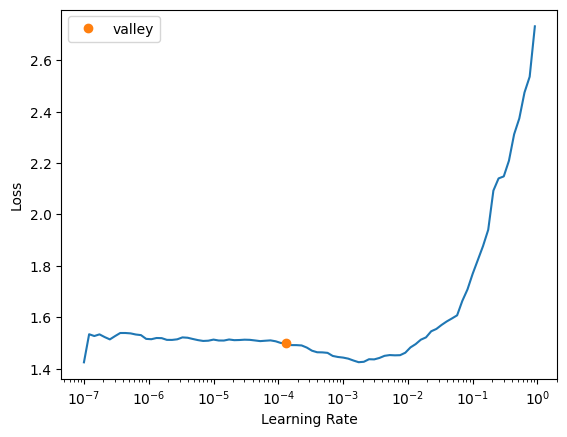

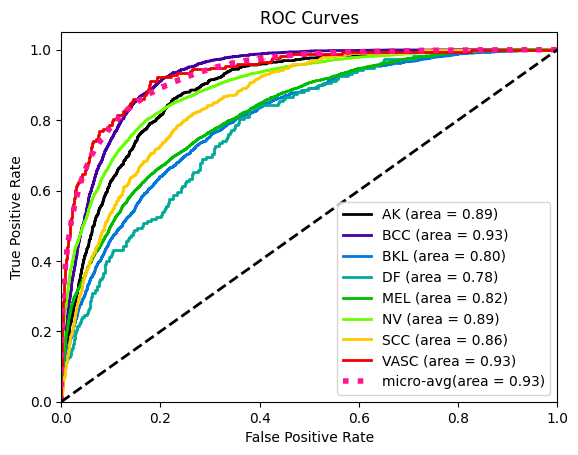

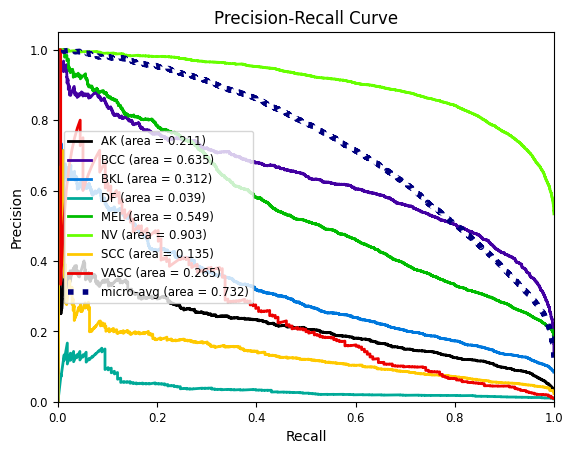

auc_dict is: {'AK': 0.21079171243097033, 'BCC': 0.6345583006497566, 'BKL': 0.3115531496746152, 'DF': 0.03894074639862617, 'MEL': 0.5492744226478048, 'NV': 0.9030770966683607, 'SCC': 0.13529228972537832, 'VASC': 0.2649959836046445}
0.6541115045547485
tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.719853,None,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1
Learning rate finder yielded lr_max: 0.0002754228771664202


epoch,train_loss,valid_loss,time
0,1.347428,None,00:16


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.42      0.10      0.16       646
         BCC       0.50      0.85      0.63      2621
         BKL       0.43      0.35      0.39      1641
          DF       0.00      0.00      0.00       158
         MEL       0.43      0.67      0.52      3424
          NV       0.88      0.70      0.78     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.64     19567
   macro avg       0.33      0.33      0.31     19567
weighted avg       0.66      0.64      0.63     19567

auc_dict is: {'AK': 0.8865693482252998, 'BCC': 0.939102586472919, 'BKL': 0.8432636222732456, 'DF': 0.8432923914326579, 'MEL': 0.8241418258890603, 'NV': 0.9020104373385008, 'SCC': 0.8730685283740955, 'VASC': 0.9683244466774568}


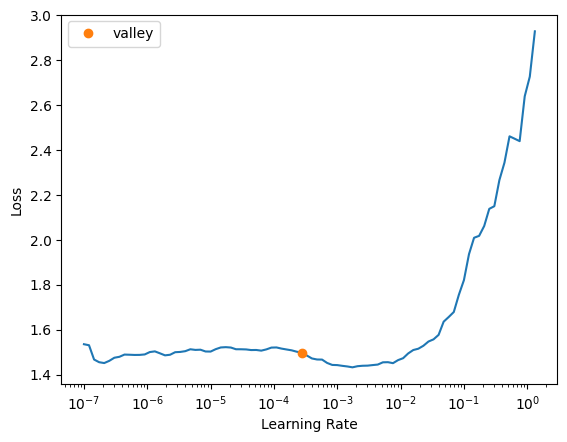

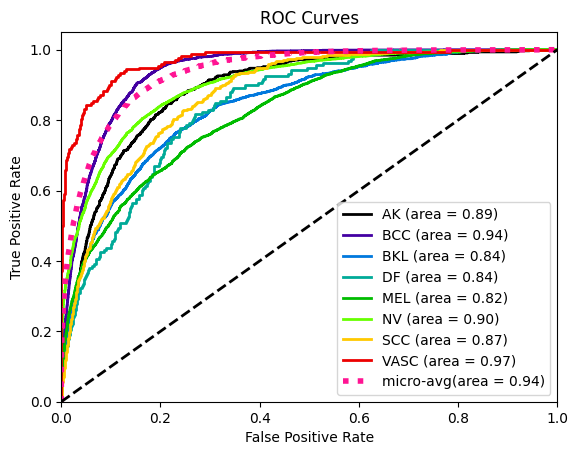

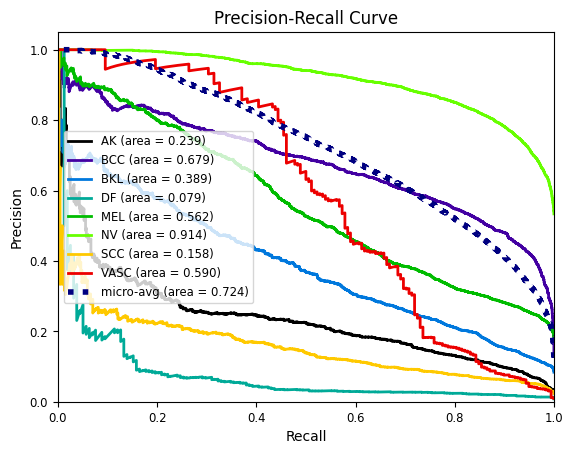

auc_dict is: {'AK': 0.23868019647957076, 'BCC': 0.6788274744098031, 'BKL': 0.3893377866543615, 'DF': 0.0793697712304404, 'MEL': 0.5615149937521142, 'NV': 0.9141181035764936, 'SCC': 0.15807836020475924, 'VASC': 0.5904732850143058}
0.6360198259353638
tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.698196,None,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2
Learning rate finder yielded lr_max: 0.0002754228771664202


epoch,train_loss,valid_loss,time
0,1.352492,None,00:17


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=supervised_pretrain_run2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.42      0.09      0.15       646
         BCC       0.54      0.81      0.65      2621
         BKL       0.42      0.31      0.35      1641
          DF       0.00      0.00      0.00       158
         MEL       0.44      0.66      0.53      3424
          NV       0.86      0.76      0.80     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.66     19567
   macro avg       0.34      0.33      0.31     19567
weighted avg       0.66      0.66      0.64     19567

auc_dict is: {'AK': 0.8835593586695732, 'BCC': 0.9360687783845383, 'BKL': 0.8374623332988631, 'DF': 0.8515731642178267, 'MEL': 0.8274134401010593, 'NV': 0.9025238313960452, 'SCC': 0.8748835091237769, 'VASC': 0.961427219534301}


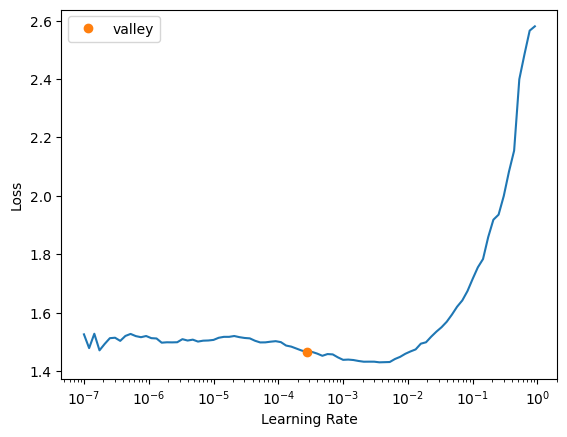

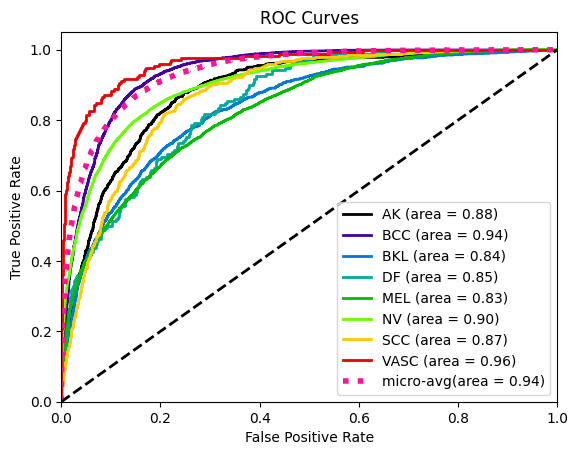

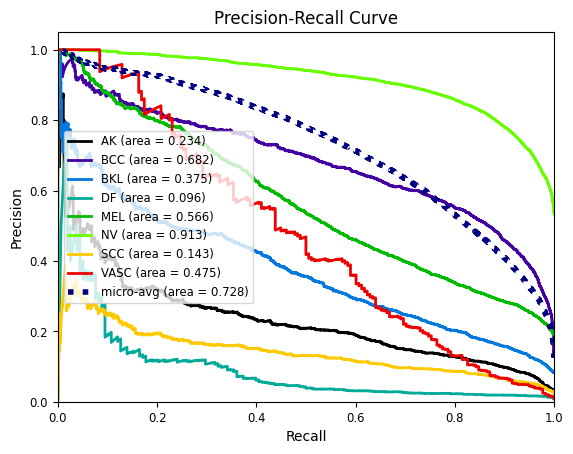

auc_dict is: {'AK': 0.23386282354593707, 'BCC': 0.6815164775745153, 'BKL': 0.37503756050293674, 'DF': 0.09568683866340072, 'MEL': 0.5657033520629775, 'NV': 0.913223165028292, 'SCC': 0.14289863040029155, 'VASC': 0.4748933830064825}
0.6561046838760376
We are saving the dictionary at supervised_pretrain


In [ ]:
#Hyperparams: description, type of intial weights, number of epochs, number of runs

#In this block we set the hps for the run. Then we call `main_tune` with these values
#########
description = 'Sup initial weights, 40 epochs'
initial_weights='supervised_pretrain'
epochs=1
runs=range(3) #we have already saved results for runs 0,1,2


tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune
sup_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

# As above but for BT initial weights:

Description: BT initial weights, 40 epochs

The general tune model path is: /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain (if None mean no saving)
The dict_path is: bt_pretrain


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Froze head


epoch,train_loss,valid_loss,time
0,1.752469,None,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0
Learning rate finder yielded lr_max: 0.0006918309954926372


epoch,train_loss,valid_loss,time
0,1.491212,None,00:16


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.56      0.01      0.02       646
         BCC       0.46      0.85      0.60      2621
         BKL       0.37      0.28      0.32      1641
          DF       0.00      0.00      0.00       158
         MEL       0.47      0.54      0.50      3424
          NV       0.85      0.77      0.81     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.64     19567
   macro avg       0.34      0.31      0.28     19567
weighted avg       0.64      0.64      0.63     19567

auc_dict is: {'AK': 0.9037812917093937, 'BCC': 0.9274117038420806, 'BKL': 0.808610189238268, 'DF': 0.7923715410637503, 'MEL': 0.8134302084581668, 'NV': 0.8889112456582459, 'SCC': 0.8632744400848209, 'VASC': 0.9083344488737678}


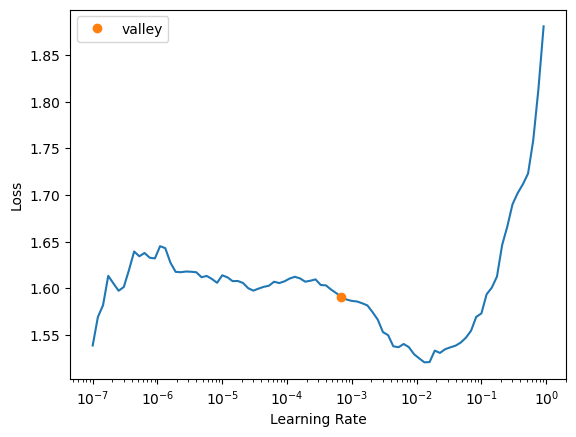

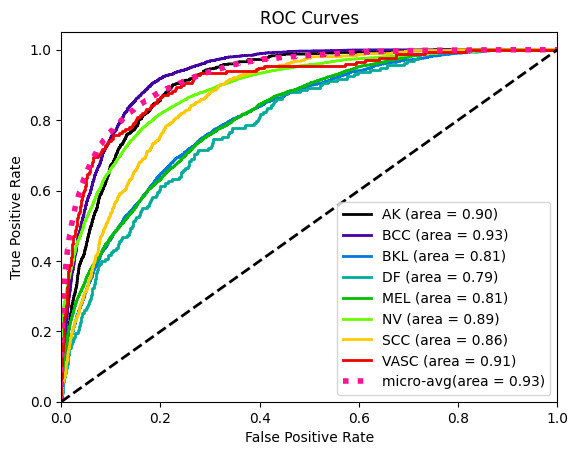

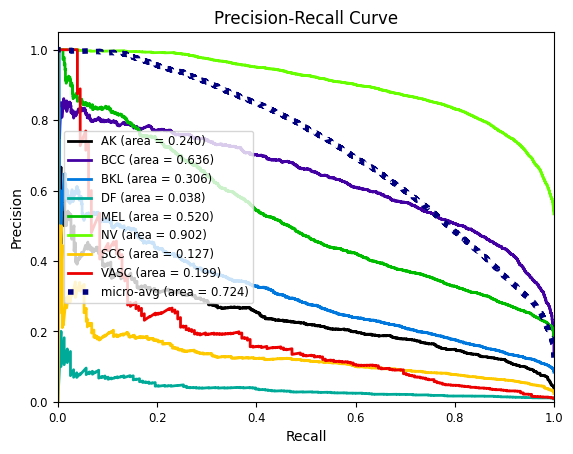

auc_dict is: {'AK': 0.24030269420013248, 'BCC': 0.6356682298472287, 'BKL': 0.30621463226598417, 'DF': 0.03779575862459227, 'MEL': 0.5204197195569875, 'NV': 0.9024119002749901, 'SCC': 0.12691084611520648, 'VASC': 0.19872950450538426}
0.6445034742355347


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Froze head


epoch,train_loss,valid_loss,time
0,1.761196,None,00:13


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1
Learning rate finder yielded lr_max: 0.0008317637839354575


epoch,train_loss,valid_loss,time
0,1.469379,None,00:16


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.00      0.00      0.00       646
         BCC       0.51      0.78      0.62      2621
         BKL       0.33      0.36      0.34      1641
          DF       0.00      0.00      0.00       158
         MEL       0.45      0.60      0.52      3424
          NV       0.85      0.75      0.80     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.64     19567
   macro avg       0.27      0.31      0.28     19567
weighted avg       0.63      0.64      0.63     19567

auc_dict is: {'AK': 0.9044857442947971, 'BCC': 0.9281735330661621, 'BKL': 0.8160357500600173, 'DF': 0.7797566834125628, 'MEL': 0.8115850338910241, 'NV': 0.8949984126886171, 'SCC': 0.8673520807363418, 'VASC': 0.8856478334466257}


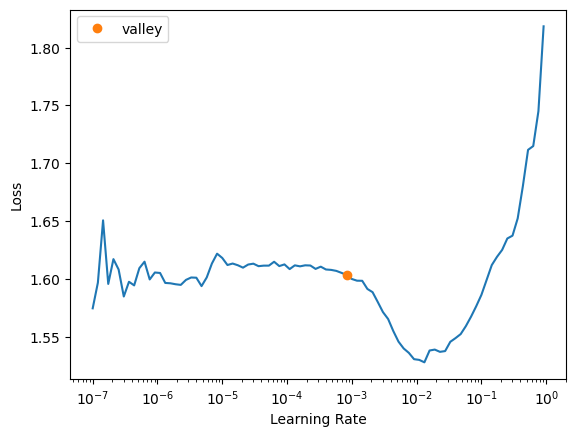

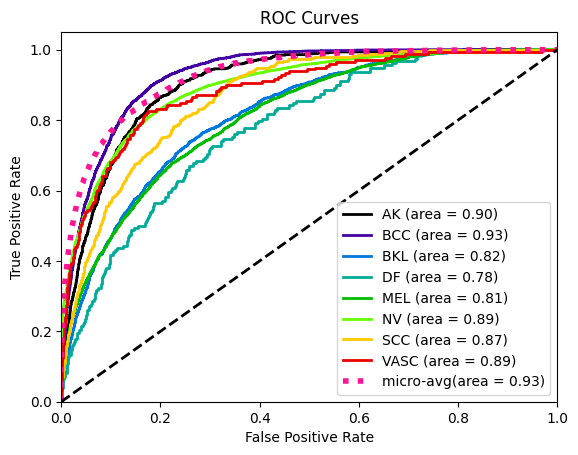

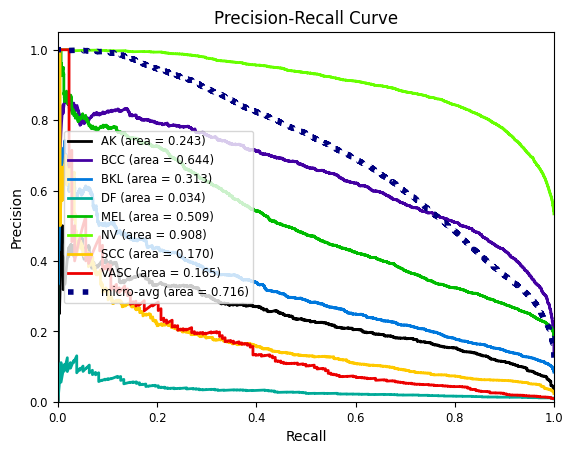

auc_dict is: {'AK': 0.24296012557030625, 'BCC': 0.6439790965208421, 'BKL': 0.3126842090496222, 'DF': 0.03416149767111454, 'MEL': 0.5089110869045319, 'NV': 0.9080994630259025, 'SCC': 0.1699921837612069, 'VASC': 0.1645616778823658}
0.6398528218269348


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tune_model_path for this run is: /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Froze head


epoch,train_loss,valid_loss,time
0,1.745709,None,00:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastprogress/

We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Unfroze head


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
We are saving after true epoch 2 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2
Learning rate finder yielded lr_max: 0.0012022644514217973


epoch,train_loss,valid_loss,time
0,1.432224,None,00:16


We are saving after true epoch 1 at path /content/gdrive/My Drive/cancer_colab/initial_weights=bt_pretrain_run2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

          AK       0.41      0.01      0.02       646
         BCC       0.50      0.82      0.62      2621
         BKL       0.35      0.31      0.33      1641
          DF       0.00      0.00      0.00       158
         MEL       0.50      0.54      0.52      3424
          NV       0.84      0.81      0.83     10444
         SCC       0.00      0.00      0.00       455
        VASC       0.00      0.00      0.00       178

    accuracy                           0.66     19567
   macro avg       0.33      0.31      0.29     19567
weighted avg       0.64      0.66      0.64     19567

auc_dict is: {'AK': 0.9025769195463687, 'BCC': 0.9328481772542925, 'BKL': 0.821850925767474, 'DF': 0.846778800908622, 'MEL': 0.8206760503814912, 'NV': 0.9001637080164849, 'SCC': 0.8686162309854231, 'VASC': 0.9536288675207361}


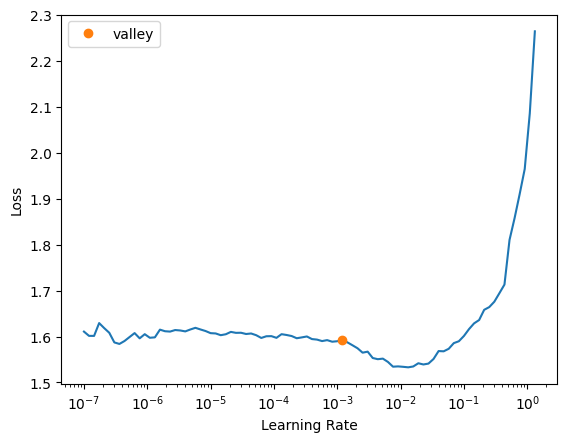

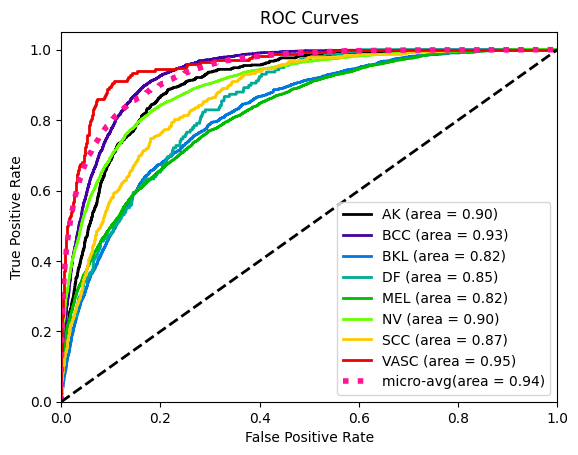

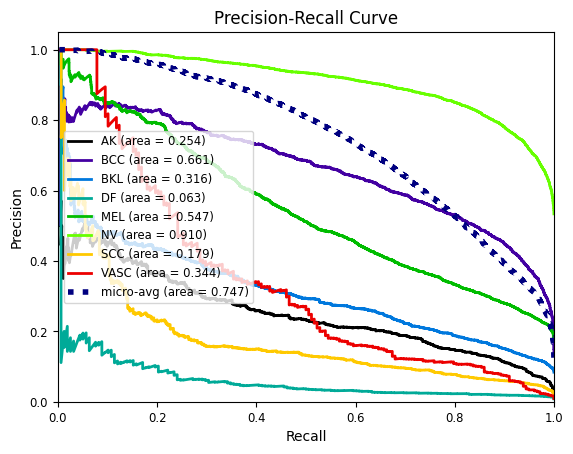

auc_dict is: {'AK': 0.25447245370259186, 'BCC': 0.6607539684935143, 'BKL': 0.31559528932500147, 'DF': 0.06319617432841344, 'MEL': 0.546679204592221, 'NV': 0.9096890891789242, 'SCC': 0.1790922077938768, 'VASC': 0.3435217313421507}
0.6644350290298462
We are saving the dictionary at bt_pretrain


In [ ]:
#In this block we set the hps for the run. Then we call `main_tune` with these values
#########
description = 'BT initial weights, 40 epochs'
initial_weights='bt_pretrain'
epochs=1

runs=range(3) #we have already saved results for runs 0,1,2

tune_model_path = save_directory + f'/initial_weights={initial_weights}'
dict_path = f'{initial_weights}' #file to load dictionary metadata

#_results=load_dict_from_gdrive(save_directory,'supervised_pretrain')
_results=None
#########

#fine tune
bt_results = main_tune(initial_weights=initial_weights,epochs=epochs,device=device,dls_tune=dls_tune,dls_test=dls_test,
                        aug_pipelines_tune=aug_pipelines_tune,aug_pipelines_test=aug_pipelines_tune,int_to_classes=int_to_classes,
                        tune_model_path=tune_model_path, dict_path = dict_path,save_directory=save_directory,description=description,
                        results=_results,runs=runs,
                        )

Verify loading and check results:

In [ ]:
sup_results = load_dict_from_gdrive(save_directory,'supervised_pretrain')

In [ ]:
lst=[sup_results[i]['acc'] for i in range(3)]
print(sup_results.keys())
print(mean(lst))
print(stdev(lst))

In [ ]:
bt_results = load_dict_from_gdrive(save_directory,'bt_pretrain')
print(bt_results.keys())
lst=[bt_results[i]['acc'] for i in range(3)]
print(mean(lst))
print(stdev(lst))

# Mean classification report for supervised weights:

In [ ]:
#sup_results=load_dict_from_gdrive(save_directory,'bt_pretrain') #how to load
mean_sup_results = Mean_Results(vocab, sup_results)

TypeError: Mean_Results() takes 1 positional argument but 2 were given

# Mean classification report for self-supervised weights:

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


NameError: name 'bt_pretrain' is not defined

In [ ]:
bt_results=load_dict_from_gdrive(save_directory,'bt_pretrain') #how to load
#mean_bt_results = Mean_Results(bt_results)
print(bt_results)
print(lst)

{0: {'AK': {'precision': 0.5555555555555556, 'recall': 0.007739938080495356, 'f1-score': 0.015267175572519083, 'support': 646}, 'BCC': {'precision': 0.46166632038229793, 'recall': 0.8477680274704311, 'f1-score': 0.5977939198278182, 'support': 2621}, 'BKL': {'precision': 0.3704600484261501, 'recall': 0.2797074954296161, 'f1-score': 0.31875000000000003, 'support': 1641}, 'DF': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 158}, 'MEL': {'precision': 0.46661627614008566, 'recall': 0.5408878504672897, 'f1-score': 0.5010144731502773, 'support': 3424}, 'NV': {'precision': 0.8464926077382825, 'recall': 0.7729797012638836, 'f1-score': 0.8080676642810671, 'support': 10444}, 'SCC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 455}, 'VASC': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 178}, 'accuracy': 0.64450350079215, 'macro avg': {'precision': 0.3375988510302965, 'recall': 0.3061353765889645, 'f1-score': 0.2801116541039602, 'support': 19567}, 'w

In [ ]:
def compute_averages(results):
    metrics = ['precision', 'recall', 'f1-score']
    averages = {category: {metric: [] for metric in metrics} for category in vocab}
    averages['accuracy'] = []
    averages['macro avg'] = {metric: [] for metric in metrics}
    averages['weighted avg'] = {metric: [] for metric in metrics}

    for run in results.values():
        if isinstance(run, dict):
            for category in vocab:
                if category in run:
                    for metric in metrics:
                        averages[category][metric].append(run[category][metric])
            averages['accuracy'].append(run['accuracy'])
            for avg_type in ['macro avg', 'weighted avg']:
                for metric in metrics:
                    averages[avg_type][metric].append(run[avg_type][metric])

    # Calculating means
    mean_averages = {}
    for category, cat_metrics in averages.items():
        if category in vocab or category in ['macro avg', 'weighted avg']:
            mean_averages[category] = {metric: np.mean(values) for metric, values in cat_metrics.items()}
        else:
            mean_averages[category] = np.mean(cat_metrics)

    return mean_averages

# Example usage
mean_averages = compute_averages(bt_results)
for category, metrics in mean_averages.items():
    print(f"{category}: {metrics}")


AK: {'precision': 0.3224400871459695, 'recall': 0.006191950464396284, 'f1-score': 0.01212777144523889}
BCC: {'precision': 0.48979107772649594, 'recall': 0.8185171054304973, 'f1-score': 0.6121454817235858}
BKL: {'precision': 0.348717554995371, 'recall': 0.3154580540320943, 'f1-score': 0.3292805345659439}
DF: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
MEL: {'precision': 0.4735635892077899, 'recall': 0.5589953271028038, 'f1-score': 0.5116951903064311}
NV: {'precision': 0.8460699980226325, 'recall': 0.7784054640623005, 'f1-score': 0.8104689922949072}
SCC: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
VASC: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
accuracy: 0.6495971107817584
macro avg: {'precision': 0.31007278838728236, 'recall': 0.3096959876365115, 'f1-score': 0.28446474629201335}
weighted avg: {'precision': 0.6399612105872486, 'recall': 0.6495971107817584, 'f1-score': 0.6321459443098628}
